# Topic Modeling - BBC News Example

## 0. Mount Google Drive

In [56]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 1. Environment Preparation

In [57]:
# Install and import packages
!pip install pyLDAvis gensim pandas==1.5.3
#!pip install --upgrade pandas==1.2

import pandas as pd # working with data
import numpy as np # working with arrays

# Topic modeling and topic visualization packages
import gensim
import pyLDAvis
import pyLDAvis.gensim

# Visualization packages
import matplotlib.pyplot as plt # data visualization
from wordcloud import WordCloud # text visualization

# NLP packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')

# General packages
import os, re, time, logging, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [58]:
# Helper functions
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    en_stopwords = stopwords.words('english')
    # Remove punctuation, numbers, and special characters
    text = ''.join([c for c in text if c.isalpha() or c.isspace()])
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Remove stop words
    words = [word for word in words if word not in en_stopwords]
    # Perform pos_tag to include nouns (NN, NNP, NNS) and verbs (VB, VBD, VBG, VBN, VBP, VBZ)
    words = [tagged_word[0] for tagged_word in pos_tag(words) if tagged_word[1].startswith('NN') or tagged_word[1].startswith('V') ]
    # Perform lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    # Remove stop words
    words = [word for word in words if word not in en_stopwords]
    # Remove words with length less than 2
    words = [word for word in words if len(word)>1]
    # Join the processed words back into a single string
    processed_text = ' '.join(words)
    return processed_text

def generate_subplot_index(total_no_of_subplots, no_of_cols):
  no_of_rows = total_no_of_subplots // no_of_cols
  if total_no_of_subplots % no_of_cols != 0:
    no_of_rows += 1
  subplot_index_list = range(1, total_no_of_subplots + 1)
  return no_of_rows, no_of_cols, subplot_index_list

def model_coherence_generator(start_topic, end_topic):
    models = []
    coherence_scores = []
    for num_topics in range(start_topic, end_topic+1):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=20, random_state=42)
        coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model,
                                                                      corpus=corpus,
                                                                      dictionary=id2word,
                                                                      topn=num_topics,
                                                                      coherence='c_v',
                                                                      texts=news_data[processed_text_tokens_feature])
        score = coherence_model.get_coherence()
        models.append(lda_model)
        coherence_scores.append(score)
    return models, coherence_scores

## 2. Data Exploration

In [59]:
# Load data into Pandas's Dataframe
news_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/BBCNewsDataset.xlsx')

# Print information about the Panda Dataframe, including the number of records, number of columns, and data types
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      1440 non-null   object
 1   Category  1440 non-null   object
dtypes: object(2)
memory usage: 22.6+ KB


In [60]:
# Display the normalized counts of unique values of the label column
pd.DataFrame(news_data['Category'].value_counts(sort=True, normalize=True))

,Category
sport,0.237500
business,0.232639
politics,0.184722
entertainment,0.182639
tech,0.162500


In [61]:
# Specify features of interest
text_feature = 'Text'
processed_text_feature = 'processed_' + text_feature
processed_text_tokens_feature = processed_text_feature + '_tokens'
label = 'Category'

news_data.head(10)

,Text,Category
0,worldcom ex-boss launches defence lawyers defe...,business
1,german business confidence slides german busin...,business
2,bbc poll indicates economic gloom citizens in ...,business
3,lifestyle governs mobile choice faster bett...,tech
4,enron bosses in $168m payout eighteen former e...,business
5,howard truanted to play snooker conservative...,politics
6,wales silent on grand slam talk rhys williams ...,sport
7,french honour for director parker british film...,entertainment
8,car giant hit by mercedes slump a slump in pro...,business
9,fockers fuel festive film chart comedy meet th...,entertainment


## 3. Data Preparation

In [62]:
# Preprocess text
news_data[processed_text_feature] = news_data[text_feature].apply(lambda x: preprocess_text(x))

# Tokenize processed text either using gensim.utils.simple_preprocess() or nltk.word_tokenize()
news_data[processed_text_tokens_feature] = news_data[processed_text_feature].apply(lambda x: gensim.utils.simple_preprocess(x))

news_data.head(10)

,Text,Category,processed_Text,processed_Text_tokens
0,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launch defence lawyer defendin...,"[worldcom, exboss, launch, defence, lawyer, de..."
1,german business confidence slides german busin...,business,business confidence business confidence fell k...,"[business, confidence, business, confidence, f..."
2,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates gloom citizen majority nati...,"[bbc, poll, indicates, gloom, citizen, majorit..."
3,lifestyle governs mobile choice faster bett...,tech,governs choice hardware going help phone firm ...,"[governs, choice, hardware, going, help, phone..."
4,enron bosses in $168m payout eighteen former e...,business,enron boss payout enron director agreed settle...,"[enron, boss, payout, enron, director, agreed,..."
5,howard truanted to play snooker conservative...,politics,truanted play snooker leader michael admitted ...,"[truanted, play, snooker, leader, michael, adm..."
6,wales silent on grand slam talk rhys williams ...,sport,wale slam talk rhys williams say wale thinking...,"[wale, slam, talk, rhys, williams, say, wale, ..."
7,french honour for director parker british film...,entertainment,honour director parker film director sir alan ...,"[honour, director, parker, film, director, sir..."
8,car giant hit by mercedes slump a slump in pro...,business,car giant hit mercedes slump profitability lux...,"[car, giant, hit, mercedes, slump, profitabili..."
9,fockers fuel festive film chart comedy meet th...,entertainment,fockers fuel film chart comedy meet fockers to...,"[fockers, fuel, film, chart, comedy, meet, foc..."


## 4. LDA Model Development, Scoring and Visualization with 5 Topics

In [63]:
# Create a gensim's LDA model and train it on your processed text corpus and visualize the generated topics top keywords
num_topics = 5
id2word = gensim.corpora.Dictionary(news_data[processed_text_tokens_feature])
print(f'type(id2word): {type(id2word)} \nlen(id2word): {len(id2word)} \nlist(id2word.items())[:5]: {list(id2word.items())[:5]}')

# Filter words that occur in less than 10 doc or more than 50% of docs
id2word.filter_extremes(no_below=10, no_above=0.5)
print(f'type(id2word): {type(id2word)} \nlen(id2word): {len(id2word)} \nlist(id2word.items())[:5]: {list(id2word.items())[:5]}')

corpus = [id2word.doc2bow(doc) for doc in news_data[processed_text_tokens_feature]]
print(f'type(corpus): {type(corpus)} \nlen(corpus): {len(corpus)} \nlen(corpus[0]):  {len(corpus[0])} \ncorpus[0][0:5]: {corpus[0][0:5]}')

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=20, random_state=42)

type(id2word): <class 'gensim.corpora.dictionary.Dictionary'> 
len(id2word): 18368 
list(id2word.items())[:5]: [(0, 'accounting'), (1, 'adjustment'), (2, 'agreed'), (3, 'alert'), (4, 'alerted')]
type(id2word): <class 'gensim.corpora.dictionary.Dictionary'> 
len(id2word): 2742 
list(id2word.items())[:5]: [(0, 'accounting'), (1, 'agreed'), (2, 'alert'), (3, 'answer'), (4, 'anything')]
type(corpus): <class 'list'> 
len(corpus): 1440 
len(corpus[0]):  81 
corpus[0][0:5]: [(0, 7), (1, 1), (2, 1), (3, 1), (4, 1)]


In [64]:
# Visualize lda model
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [65]:
# Compute Coherence Score
coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model,
                                                              corpus=corpus,
                                                              dictionary=id2word,
                                                              topn=num_topics,
                                                              coherence='c_v',
                                                              texts=news_data[processed_text_tokens_feature])
coherence = coherence_model.get_coherence()
print(f'Coherence score: {coherence}')

Coherence score: 0.6437877386809083


In [66]:
# Get the topic distribution for each doc
topic_dist = [lda_model[doc] for doc in corpus]
print(f"type(topic_dist): {type(topic_dist)} \nlen(topic_dist): {len(topic_dist)} \ntopic_dist[10][0:]: {topic_dist[10][0:]}")

# Get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]
scores =[max(topic, key=lambda x:x[1])[1] for topic in topic_dist]
print(f"type(scores): {type(scores)} \nlen(scores): {len(scores)} \nscores[0:10] {scores[0:10]}")

# Create a dataframe to show dominant topic for each doc
news_dominant_topic = news_data[[text_feature, label]].copy()
news_dominant_topic['Dominant_Topic'] = [topic+1 for topic in dominant_topic]
news_dominant_topic['Contribution%'] = [round(score*100,2) for score in scores]
news_dominant_topic.head()

type(topic_dist): <class 'list'> 
len(topic_dist): 1440 
topic_dist[10][0:]: [(2, 0.6000959), (4, 0.39690578)]
type(scores): <class 'list'> 
len(scores): 1440 
scores[0:10] [0.5098876, 0.99241793, 0.9944245, 0.9960777, 0.54734176, 0.41990045, 0.99264675, 0.7099377, 0.994425, 0.89461654]


,Text,Category,Dominant_Topic,Contribution%
0,worldcom ex-boss launches defence lawyers defe...,business,5,50.99
1,german business confidence slides german busin...,business,5,99.24
2,bbc poll indicates economic gloom citizens in ...,business,5,99.44
3,lifestyle governs mobile choice faster bett...,tech,1,99.61
4,enron bosses in $168m payout eighteen former e...,business,5,54.73


In [67]:
news_dominant_topic.groupby(['Dominant_Topic', label])[label].count()

Dominant_Topic  Category     
1               business           8
                entertainment      3
                politics           4
                tech             214
2               politics           2
                sport            313
                tech               2
3               business          29
                entertainment     15
                politics          33
                sport             26
                tech               8
4               business           1
                entertainment    239
                politics           3
                sport              2
                tech               2
5               business         297
                entertainment      6
                politics         224
                sport              1
                tech               8
Name: Category, dtype: int64

Subplot index info: (no_of_rows=3, no_of_cols=2, subplot_index_list=range(1, 6)


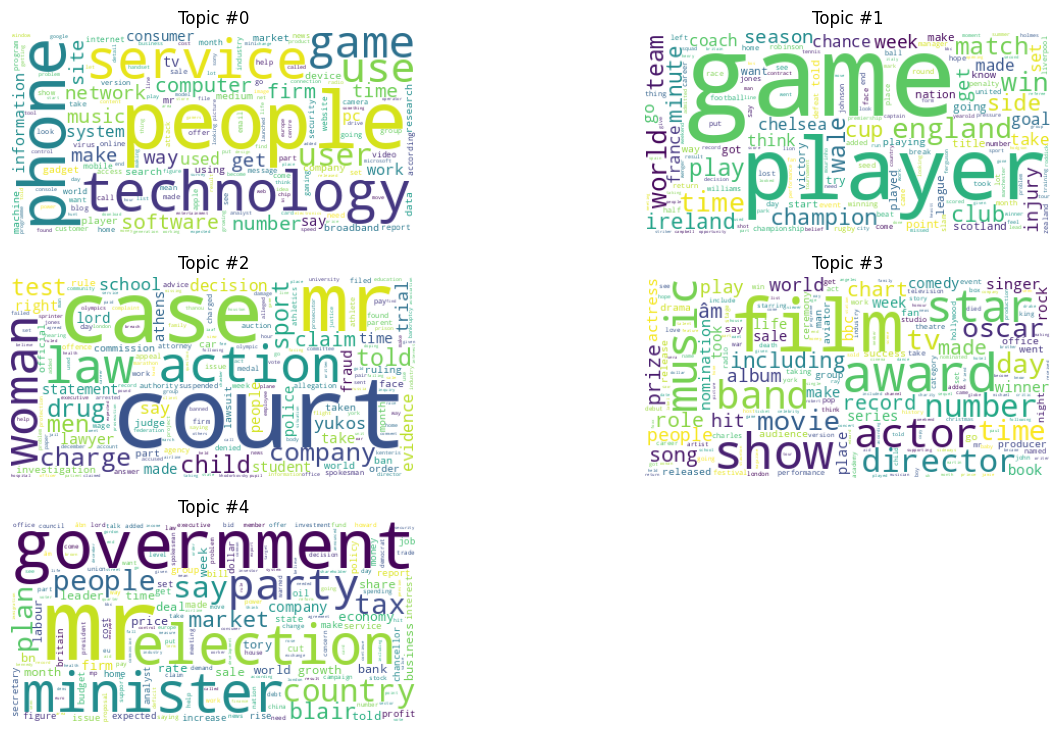

In [68]:
# Create wordcloud of topics' top keywords
num_keywords = 200
no_of_rows, no_of_cols, subplot_index_list = generate_subplot_index(total_no_of_subplots=lda_model.num_topics, no_of_cols=2)
print(f"Subplot index info: (no_of_rows={no_of_rows}, no_of_cols={no_of_cols}, subplot_index_list={subplot_index_list}")
fig = plt.figure(1, figsize=(15, 3*no_of_rows))

for i in range(lda_model.num_topics):
  ax = fig.add_subplot(no_of_rows, no_of_cols, subplot_index_list[i])
  ax.imshow(WordCloud(background_color='white').fit_words(dict(lda_model.show_topic(i, num_keywords))))
  ax.axis("off")
  ax.set_title(f"Topic #{i}")
plt.show()

## 5. LDA Model Development, Scoring and Visualization with 5 to 10 Topics

In [69]:
# Get the coherence scores by varing the number of topics from 5 to 10 with step=1
min_topics = 5
max_topics = 10
lda_models, coherence_scores = model_coherence_generator(start_topic=min_topics, end_topic=max_topics)

coherence_scores: [0.6437877386809083, 0.5890131064248625, 0.5747905215618301, 0.6050390858791773, 0.5842696811897015, 0.6005952145617974]
Number of topics with maximum coherence score: 5


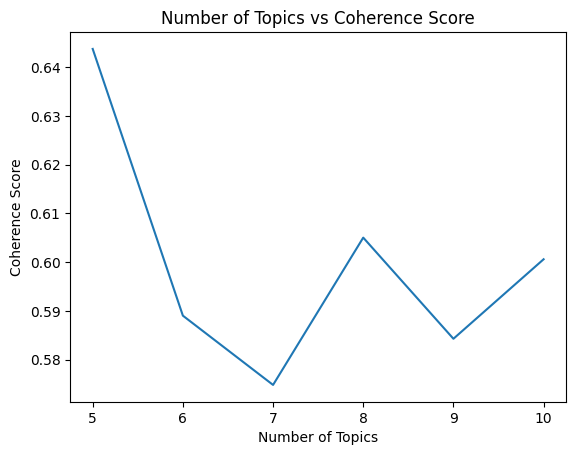

In [70]:
# Compute Coherence Scores
print(f'coherence_scores: {coherence_scores}')
print(f'Number of topics with maximum coherence score: {np.argmax(coherence_scores)+min_topics}')

#Plot the number of topics vs coherence score
x_ax = range(min_topics, max_topics+1)
y_ax = coherence_scores
plt.plot(x_ax, y_ax)
plt.title('Number of Topics vs Coherence Score')
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

In [71]:
# Visualize best lda model
vis = pyLDAvis.gensim.prepare(lda_models[np.argmax(coherence_scores)], corpus, id2word)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [72]:
best_lda_model = lda_models[np.argmax(coherence_scores)]
best_lda_model.show_topics(num_words=20, formatted=False)

[(0,
  [('people', 0.017896857),
   ('phone', 0.011231952),
   ('technology', 0.010204467),
   ('service', 0.009552945),
   ('game', 0.008378214),
   ('use', 0.0071304846),
   ('user', 0.0070520826),
   ('computer', 0.006780862),
   ('firm', 0.006656726),
   ('software', 0.006616225),
   ('music', 0.0060776016),
   ('way', 0.0058260956),
   ('make', 0.005733654),
   ('number', 0.00557273),
   ('time', 0.005510728),
   ('network', 0.0054584607),
   ('get', 0.0054497654),
   ('site', 0.0054469155),
   ('system', 0.0053184605),
   ('used', 0.0052913777)]),
 (1,
  [('game', 0.018461438),
   ('player', 0.010883137),
   ('england', 0.010175321),
   ('time', 0.009238942),
   ('world', 0.008756319),
   ('win', 0.008630811),
   ('match', 0.0073499708),
   ('play', 0.00704163),
   ('team', 0.006953125),
   ('wale', 0.0069401977),
   ('side', 0.0065603866),
   ('club', 0.0065086535),
   ('champion', 0.0063938727),
   ('cup', 0.00603514),
   ('ireland', 0.0058597466),
   ('minute', 0.005700493),
 

In [73]:
#get the topic distribution for each doc
topic_dist = [best_lda_model[doc] for doc in corpus]
print(f"type(topic_dist): {type(topic_dist)} \nlen(topic_dist): {len(topic_dist)} \ntopic_dist[10][0:]: {topic_dist[10][0:]}")

#get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]
scores =[max(topic, key=lambda x:x[1])[1] for topic in topic_dist]
print(f"type(scores): {type(scores)} \nlen(scores): {len(scores)} \nscores[0:10] {scores[0:10]}")

#Create a dataframe to show dominant topic for each doc
news_dominant_topic = news_data[[text_feature, label]].copy()
news_dominant_topic['Dominant_Topic'] = [topic+1 for topic in dominant_topic]
news_dominant_topic['Contribution%'] = [round(score*100,2) for score in scores]
news_dominant_topic.head()

type(topic_dist): <class 'list'> 
len(topic_dist): 1440 
topic_dist[10][0:]: [(2, 0.6000959), (4, 0.39690578)]
type(scores): <class 'list'> 
len(scores): 1440 
scores[0:10] [0.5098876, 0.99241793, 0.9944245, 0.9960777, 0.54734176, 0.41990045, 0.99264675, 0.7099377, 0.994425, 0.89461654]


,Text,Category,Dominant_Topic,Contribution%
0,worldcom ex-boss launches defence lawyers defe...,business,5,50.99
1,german business confidence slides german busin...,business,5,99.24
2,bbc poll indicates economic gloom citizens in ...,business,5,99.44
3,lifestyle governs mobile choice faster bett...,tech,1,99.61
4,enron bosses in $168m payout eighteen former e...,business,5,54.73


In [74]:
news_dominant_topic.groupby(['Dominant_Topic', label])[label].count()

Dominant_Topic  Category     
1               business           8
                entertainment      3
                politics           4
                tech             214
2               politics           2
                sport            313
                tech               2
3               business          29
                entertainment     15
                politics          33
                sport             26
                tech               8
4               business           1
                entertainment    239
                politics           3
                sport              2
                tech               2
5               business         297
                entertainment      6
                politics         224
                sport              1
                tech               8
Name: Category, dtype: int64

In [75]:
news_dominant_topic.groupby(['Dominant_Topic']).count()

,Text,Category,Contribution%
Dominant_Topic,,,
1,229,229,229
2,317,317,317
3,111,111,111
4,247,247,247
5,536,536,536


In [76]:
news_dominant_topic.groupby(['Dominant_Topic'])[text_feature].count()

Dominant_Topic
1    229
2    317
3    111
4    247
5    536
Name: Text, dtype: int64

In [77]:
# Count and percentage of docs for each topic
news_dominant_topic_summary = news_dominant_topic.groupby('Dominant_Topic')[text_feature].count().copy().reset_index()
news_dominant_topic_summary.rename(columns={'Text':'num_docs'}, inplace=True)
news_dominant_topic_summary['Percentage%'] = round(news_dominant_topic_summary['num_docs']/news_dominant_topic.shape[0]*100,2)
news_dominant_topic_summary=news_dominant_topic_summary.sort_values('num_docs', ascending=False).reset_index(drop=True)
news_dominant_topic_summary

,Dominant_Topic,num_docs,Percentage%
0,5,536,37.22
1,2,317,22.01
2,4,247,17.15
3,1,229,15.90
4,3,111,7.71


Subplot index info: (no_of_rows=3, no_of_cols=2, subplot_index_list=range(1, 6)


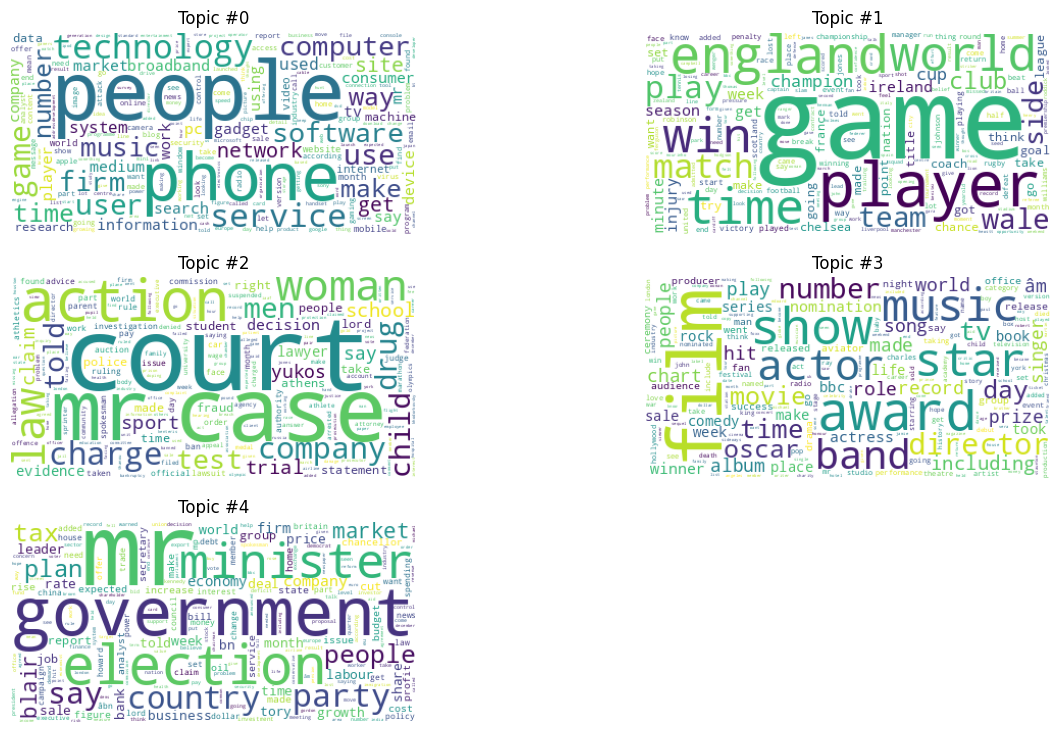

In [78]:
no_of_rows, no_of_cols, subplot_index_list = generate_subplot_index(total_no_of_subplots=best_lda_model.num_topics, no_of_cols=2)
print(f"Subplot index info: (no_of_rows={no_of_rows}, no_of_cols={no_of_cols}, subplot_index_list={subplot_index_list}")
fig = plt.figure(1, figsize=(15, 3*no_of_rows))

for i in range(best_lda_model.num_topics):
  ax = fig.add_subplot(no_of_rows, no_of_cols, subplot_index_list[i])
  ax.imshow(WordCloud(background_color='white').fit_words(dict(best_lda_model.show_topic(i, 200))))
  ax.axis("off")
  ax.set_title(f"Topic #{i}")
plt.show()